In [1]:
# 安装依赖库
!pip install git+https://github.com/openai/CLIP.git -q
!pip install transformers -q
!pip install openfoodfacts -q
!pip install torchvision matplotlib -q

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from transformers import pipeline
import openfoodfacts

# 设置随机种子保证可重复性
torch.manual_seed(42)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.4 MB/s eta 0:00:00


In [2]:
from PIL import Image

In [3]:
# ------------------
# 食材识别模块
# ------------------
def image_recognition():
    # 加载CLIP模型
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # 定义食材候选列表（可根据需要扩展）
    ingredient_list = [
        "apple", "banana", "carrot", "broccoli", "tomato",
        "potato", "onion", "chicken", "egg", "flour",
        "milk", "cheese", "fish", "beef", "sugar",
        "Corn", "Meatloaf"
    ]



    image_path = "/content/00001001.jpg"
    img = Image.open(image_path).convert("RGB")

    # 预处理和模型推理
    image = preprocess(img).unsqueeze(0).to(device)
    text = clip.tokenize([f"a photo of {ingredient}" for ingredient in ingredient_list]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        logits_per_image, _ = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # 获取预测结果
    top_k = 3
    top_indices = probs.argsort()[0][-top_k:][::-1]
    predicted_ingredients = [ingredient_list[i] for i in top_indices]

    # 显示结果（假设真实标签为已知）
    true_ingredients = ["Meatloaf", "Corn"]  # 示例图片真实标签

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {', '.join(predicted_ingredients)}\nTrue: {', '.join(true_ingredients)}")
    plt.show()

    return predicted_ingredients

In [5]:
# ------------------
# 食谱推荐模块
# ------------------
def recipe_recommendation(ingredients):
    generator = pipeline('text-generation', model='gpt2-medium')

    prompt = f"Create a detailed recipe using {', '.join(ingredients)}:\n1."
    recipe = generator(
        prompt,
        max_length=300,
        num_return_sequences=1,
        temperature=0.7,
        top_p=0.9
    )

    print("\nGenerated Recipe:")
    print(recipe[0]['generated_text'])

In [6]:
# ------------------
# 营养分析模块
# ------------------
def nutritional_analysis(ingredients):
    print("\nNutritional Analysis (per 100g):")

    nutrition = {
        'energy': 0,
        'fat': 0,
        'carbohydrates': 0,
        'proteins': 0
    }

    for ingredient in ingredients:
        try:
            products = openfoodfacts.products.search(ingredient)
            if products['products']:
                product = products['products'][0]
                nutriments = product.get('nutriments', {})

                nutrition['energy'] += nutriments.get('energy-kcal_100g', 0) or 0
                nutrition['fat'] += nutriments.get('fat_100g', 0) or 0
                nutrition['carbohydrates'] += nutriments.get('carbohydrates_100g', 0) or 0
                nutrition['proteins'] += nutriments.get('proteins_100g', 0) or 0
        except:
            continue

    print(f"Calories: {nutrition['energy']:.1f} kcal")
    print(f"Fat: {nutrition['fat']:.1f} g")
    print(f"Carbohydrates: {nutrition['carbohydrates']:.1f} g")
    print(f"Proteins: {nutrition['proteins']:.1f} g")


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 41.5MiB/s]


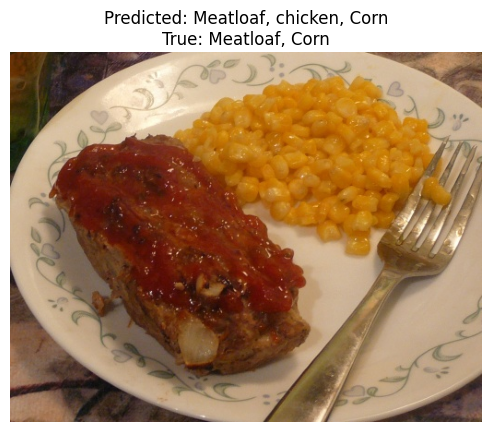

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
# ------------------
# 主程序
# ------------------
if __name__ == "__main__":
    # 执行图像识别
    detected_ingredients = image_recognition()

    # 食谱推荐
    recipe_recommendation(detected_ingredients)

    # 营养分析
    nutritional_analysis(detected_ingredients)